In [ ]:
import pandas as pd
import numpy as np

# 300 patients collected

In [ ]:
# data availabel on request - please contact creators of CORONET
df = pd.read_excel(path + '...\data.xlsx', index_col=0)

df - data frame with data for all available patients

# Eliminate patients without valid outcome


There are 7 unique recorded outcomes:
- Discharged within 24 hours
- Admitted for non-COVID-19 reason
- Admitted for COVID-19 no O2
- Admitted plus O2
- Admitted plus ITU
- COVID-19 death
- Death due to other


Remove records with missing outcome:

In [ ]:
df=df.dropna(subset=['Worst Outcome']).reset_index(drop=True)

In some records we observe missing information whether a patient recived respiratory support ('Required oxygen'). Thus we followed assumptions listed below:
- every patient that died due to COVID got also O2 during hospital stay (11 patients with missing value)
- patients discharged within first 24h didn't get O2 (2 patients with missing value)
- inpt for non-Covid reason admitted and survivied didn't get O2 (2 patients with missing value)
- patients admitted and admitted to ITU got O2 (2 patients with missing value)

In [ ]:
df.loc[df['Required oxygen'].isna() & (df['Worst Outcome'] == 'COVID-19 death'),'Required oxygen'] = 1.

df.loc[df['Required oxygen'].isna() & (df['Worst Outcome'] == 'Discharged within 24 hours'),'Required oxygen'] = 0.

df.loc[df['Required oxygen'].isna() & (df['Worst Outcome'] == 'Admitted for non-COVID-19 reason'),'Required oxygen'] = 0.

df.loc[df['Required oxygen'].isna() & (df['Worst Outcome'] == 'Admitted plus ITU'),'Required oxygen'] = 1

# Multiple imputation for records where <=2 missing numeric paramters

Select patients where only 2 biochemistry parameters are missing:

In [ ]:
params_num = ['NEWS2','CRP_day0','Neutro_lympho_ratio_day0','Platelets','Albumin']

In [ ]:
index_less2miss = (df[params_num].isna().sum(axis=1) <= 2)

df = df[index_less2miss]

Transform CRP and NLR to log scale, in order to change the shape of distribution:

In [ ]:
df['log2_CRP'] = np.log2(df['CRP_day0']+1)

df['log2_NLR'] = np.log2(df['Neutro_lympho_ratio_day0']+1)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

estimator = BayesianRidge()

imputer = IterativeImputer(estimator=estimator)

In [ ]:
# impute the date using iterative imputer with Bayesian Ridge estimator
data_imputed = imputer.fit_transform(df[param_to_imp])

data_imputed=pd.DataFrame(data = data_imputed, columns=param_to_imp, index = df.index)

data_imputed

Add imputed values to df:

In [ ]:
df[data_imputed.columns] = data_imputed

# Defining combined outcome 

In [ ]:
df['Outcome_covid_only'] = 0

df.loc[df['Admitted'] == 1, 'Outcome_covid_only'] =1

df.loc[df['Required oxygen'] == 1, 'Outcome_covid_only'] =2

df.loc[df['Death_covid'] == 1, 'Outcome_covid_only'] =3

# Random Forest model

In [ ]:
X_cols = [ 'Age',
          'Total_nb_comorbidities', 
          'haematological_cancer',
          'Cancer_stage_12',
          'Cancer_stage_3',
          'Cancer_stage_4',
          'NEWS2',
          'Platelets',
          'Albumin',
          'log2_CRP',
          'log2_NLR']
          
y_col = 'Outcome_covid_only'

In [ ]:
# independent variables
X = df[X_cols].values

# dependent variable
y = df[y_col].values

## LeaveOneOut cross-validation of the model

The code in this subsection was used to compute CORONET scores in model validation phase, which is highlighted in red box in the diagram below (Fig. 1 in the paper).

CORONET scores were calculated for 279 patients using Leave-One-Out Cross Validation approach. The scores are presented in Fig. 3 in the paper, and as a dot plot on the CORONET website.

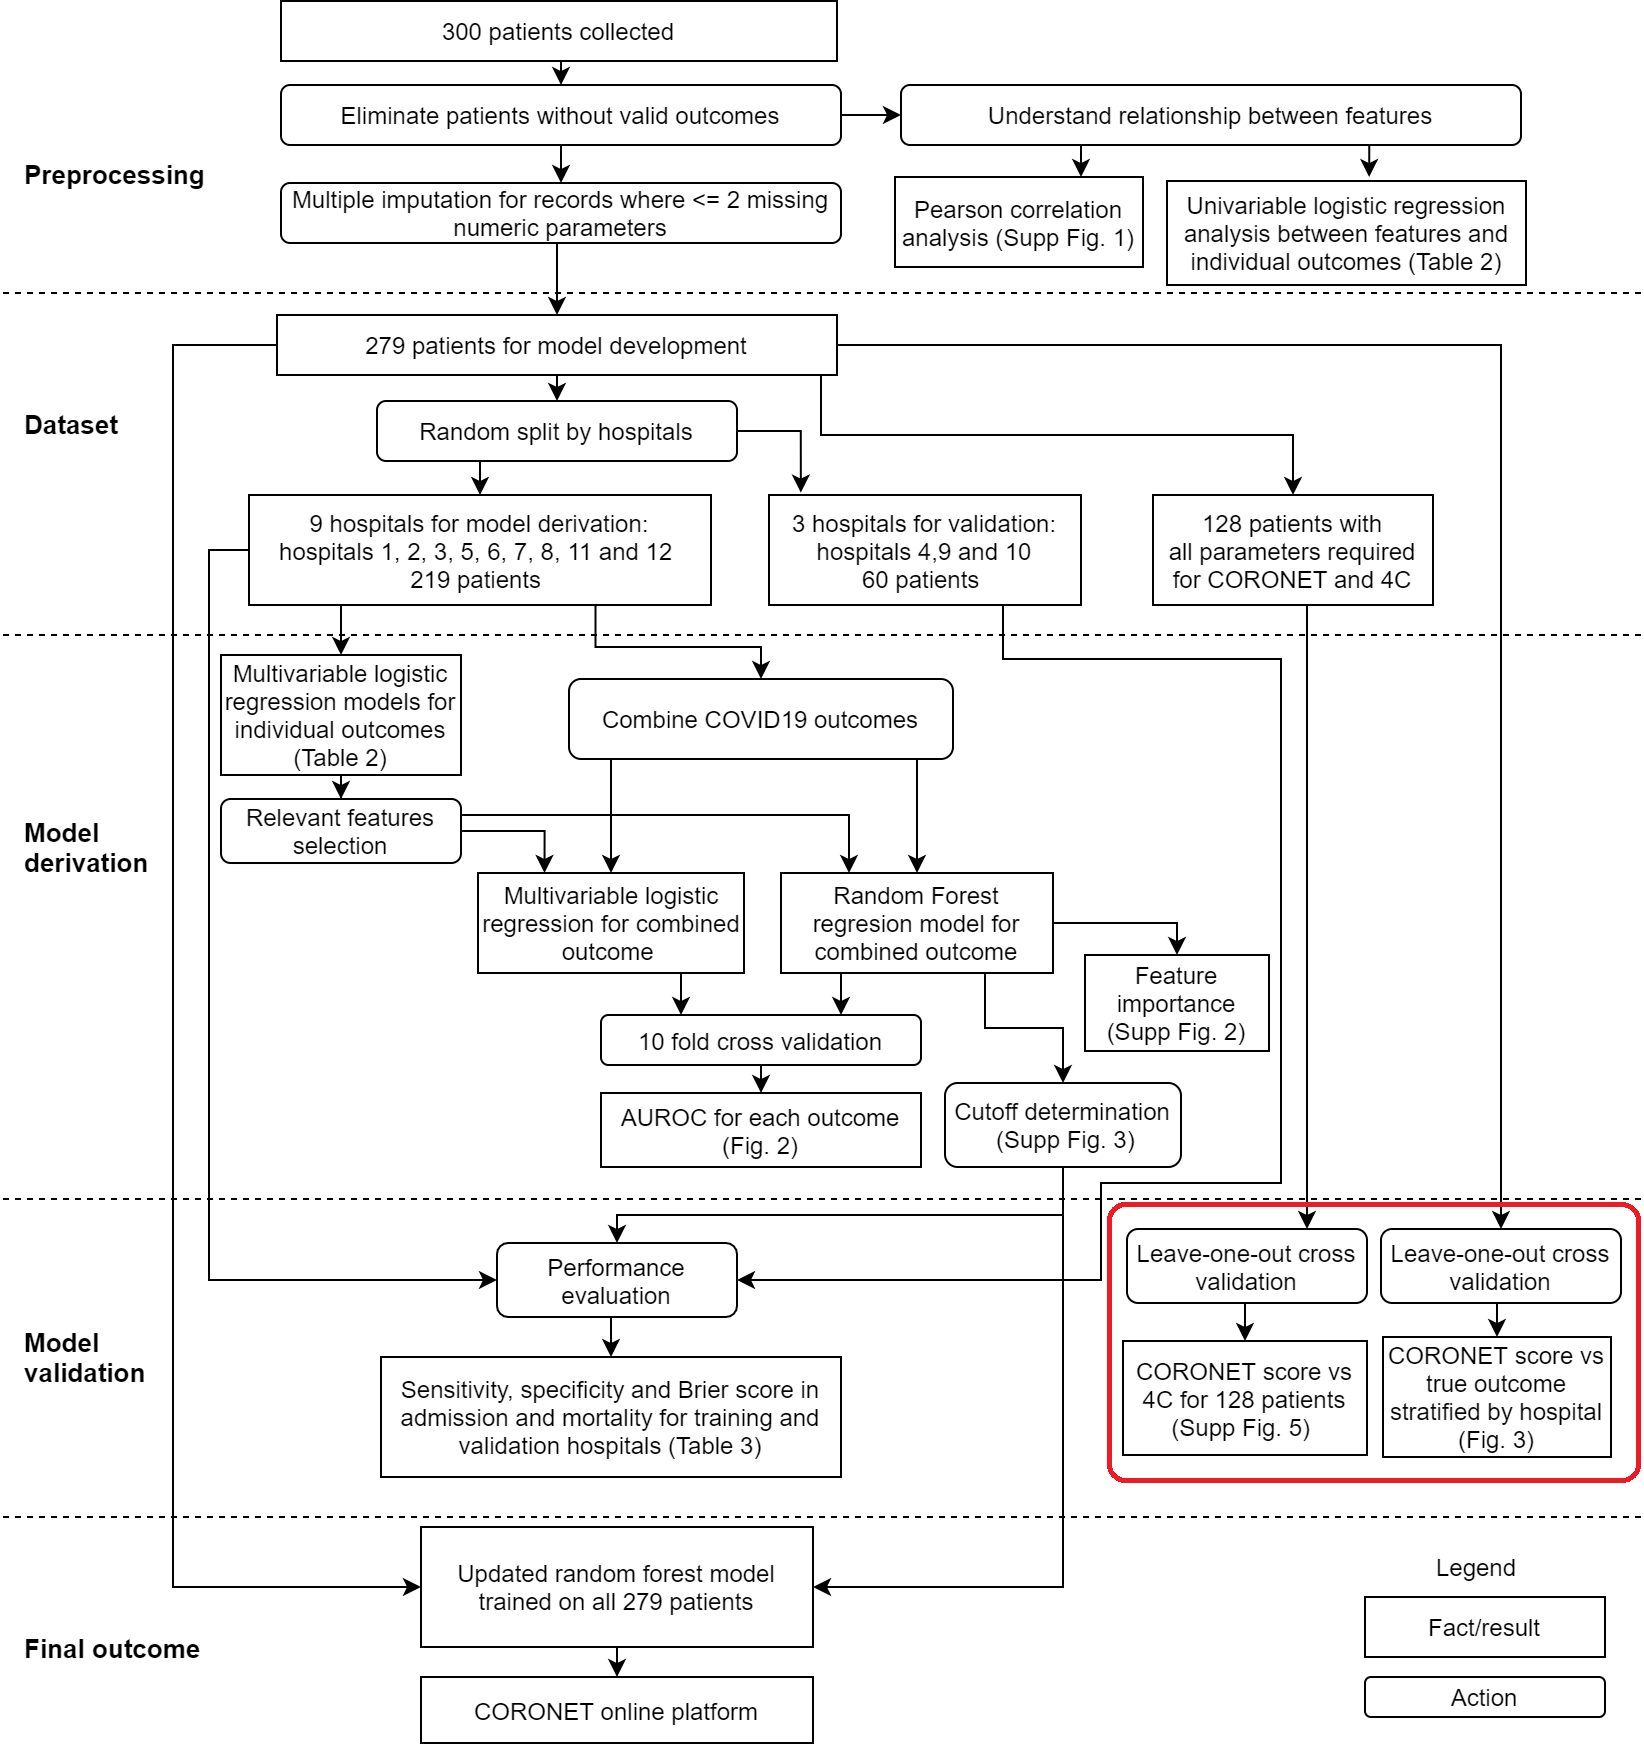

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

In [ ]:
loo = LeaveOneOut()
y_true, y_pred = list(), list()
np.random.seed(0)

for train_ix, test_ix in loo.split(X):
    
    # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # fit model
    model = RandomForestRegressor(n_estimators=500, max_depth=3)
    model.fit(X_train, y_train)
    
    # evaluate model
    yhat = model.predict(X_test)
    
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])

    
y_true # true outcomes for 279 patients
y_pred # CORONET scores for 279 patients

## Training the final CORONET model

The final model was trained on the whole available cohort: 279 patients.

This step is highlighted in red box below (Fig. 1 in the paper).

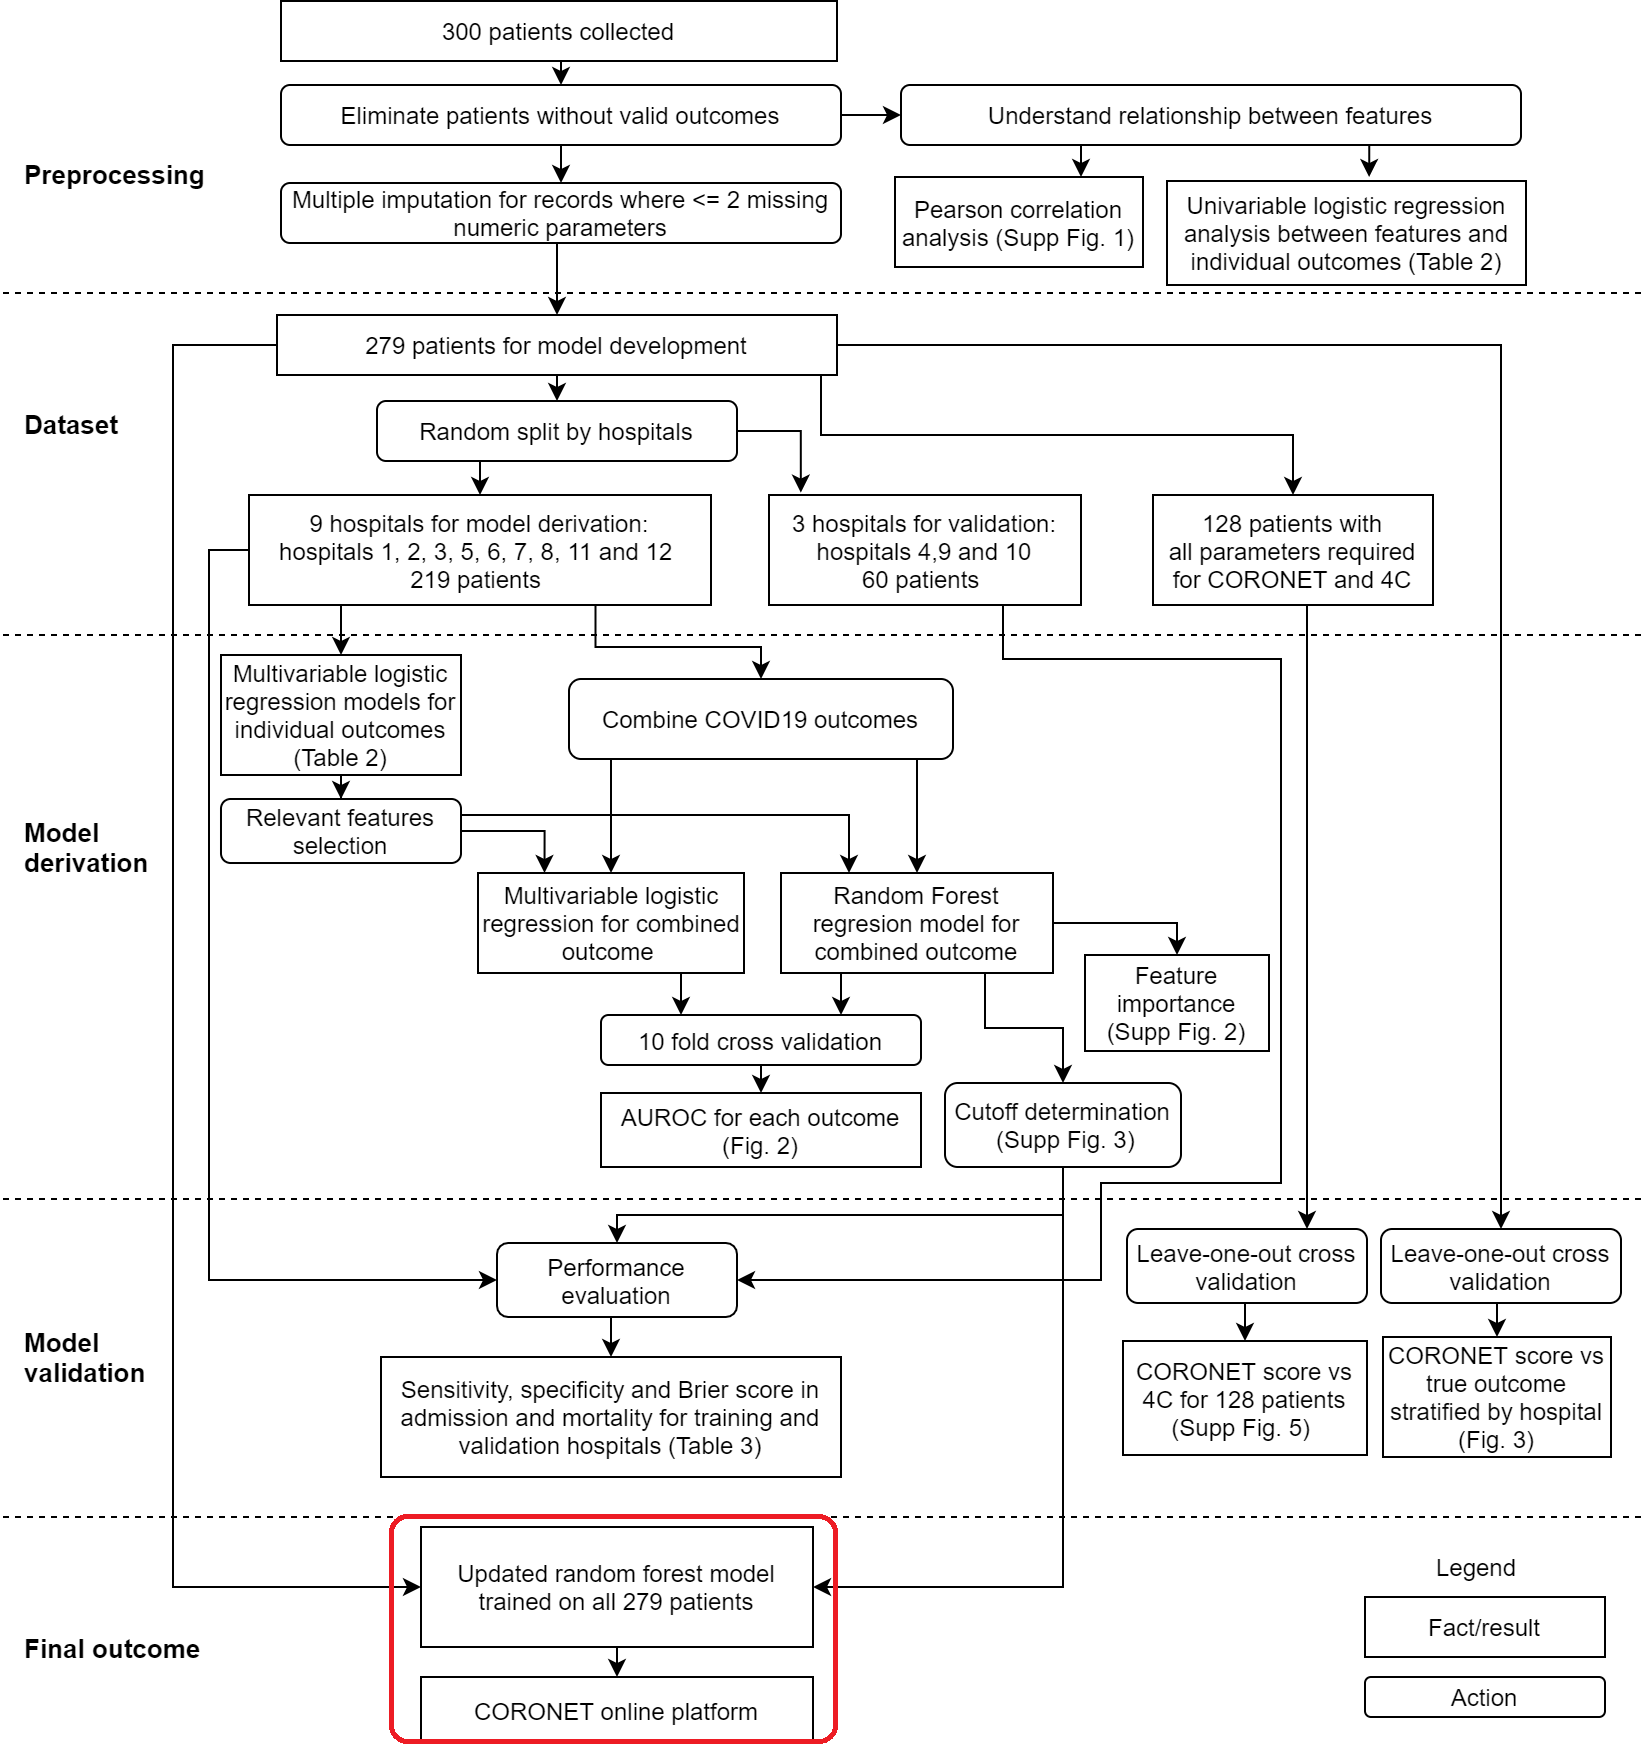

In [ ]:
np.random.seed(1234)

coronet_RF_model = RandomForestRegressor(n_estimators=1000, max_depth=3)
coronet_RF_model.fit(X, y)

y_pred = coronet_RF_model.predict(X)
y_true = y

Save the final CORONET model to pickle file, then run in on the website.

In [ ]:
import joblib
joblib_file = r'...\CORONET_RF_model.pkl'
joblib.dump(coronet_RF_model, joblib_file)

## Create SHAP explainer

In [ ]:
import shap

In [ ]:
coronet_explainer = shap.Explainer(coronet_RF_model, X)

Save CORONET explainer to pickle file, then run in on the website to generate barplot explaining the contribution of each feature to the recommendation.

In [ ]:
joblib_file = r'...\CORONET.pkl'
joblib.dump(coronet_explainer, joblib_file)